<a href="https://colab.research.google.com/github/mehrotrasan16/Keras-Deep-Learning/blob/02-horsesvhumans-MobileNetV2Finetune-BinaryClassification/A2_Q3_MobileNetV2_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

# Loading and Preprocessing the Data

In [2]:
(raw_data, raw_validation,raw_test), metadata = tfds.load(
    'horses_or_humans',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True
)  

In [3]:
print(raw_data,raw_validation,raw_test)

<DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)> <DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)> <DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>


In [4]:
get_label_name = metadata.features['label'].int2str

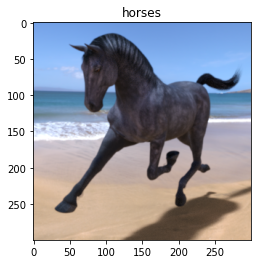

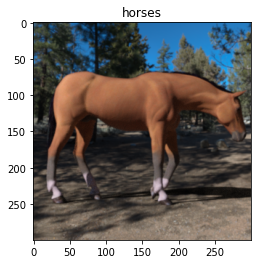

In [5]:
for image,label in raw_data.shuffle(1024).take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [6]:
IMG_SIZE=160

def format_example(image,label):
    image=tf.cast(image,tf.float32)
    #normalizing the values
    image=(image/127.5) - 1
    #scaling the image
    image=tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
    return image,label

In [7]:
train = raw_data.map(format_example)
validation=raw_validation.map(format_example)
test=raw_test.map(format_example)

In [8]:
validation,test

(<DatasetV1Adapter shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>,
 <DatasetV1Adapter shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>)

# Batching the Data"

In [9]:
BATCH_SIZE=32
SHUFFLE_BUFFER_SIZE=1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches=validation.batch(BATCH_SIZE)
test_batches=test.batch(BATCH_SIZE)

for image_batch,label_batch in train_batches.take(1):
    pass
image_batch.shape

TensorShape([32, 160, 160, 3])

# Loading the MobileNetV2 Model

In [10]:
IMG_SHAPE=(IMG_SIZE,IMG_SIZE,3)

base_model=tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
feature_batch=base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [11]:
base_model.trainable=False

In [12]:
global_average_layer=tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average=global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [13]:
prediction_layer = keras.layers.Dense(1)
prediction_batch=prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [14]:
model=keras.Sequential([
                        base_model,
                        global_average_layer,
                        prediction_layer
])

In [15]:
base_learning_rate=0.0001
model.compile(
    optimizer=keras.optimizers.RMSprop(lr=base_learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics='accuracy'
)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


## Initial Shallow Training

In [17]:
checkpoint_filepath='weights.{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

In [18]:
initial_epochs=10
history = model.fit(
    train_batches,
    epochs=initial_epochs,
    validation_data=validation_batches,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
     26/Unknown - 14s 537ms/step - loss: 0.5556 - accuracy: 0.7117WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 17s 657ms/step - loss: 0.5556 - accuracy: 0.7117 - val_loss: 0.5059 - val_accuracy: 0.9020
Epoch 2/10
26/26 [==============================] - ETA: 0s - loss: 0.4046 - accuracy: 0.8723WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 16s 629ms/step - loss: 0.4046 - accuracy: 0.8723 - val_loss: 0.3767 - val_accuracy: 0.9314
Epoch 3/10
26/26 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.9234WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 16s 631ms/step - loss: 0.3016 - accuracy: 0.9234 - val_loss: 0.2841 - val_accuracy: 0.9608
Epoch 4/10
26/26 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9720WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 17s 635ms/step - loss: 0.2238 - accuracy: 0.9720 - val_loss: 0.2132 - val_accuracy: 0.9706
Epoch 5/10
26/26 [==============================] - ETA: 0s - loss: 0.1649 - accuracy: 0.9903WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 17s 640ms/step - loss: 0.1649 - accuracy: 0.9903 - val_loss: 0.1628 - val_accuracy: 0.9902
Epoch 6/10
26/26 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.9939WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 16s 632ms/step - loss: 0.1228 - accuracy: 0.9939 - val_loss: 0.1253 - val_accuracy: 1.0000
Epoch 7/10
26/26 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9976WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 16s 634ms/step - loss: 0.0928 - accuracy: 0.9976 - val_loss: 0.0982 - val_accuracy: 1.0000
Epoch 8/10
26/26 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 16s 633ms/step - loss: 0.0699 - accuracy: 1.0000 - val_loss: 0.0745 - val_accuracy: 1.0000
Epoch 9/10
26/26 [==============================] - ETA: 0s - loss: 0.0533 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 16s 631ms/step - loss: 0.0533 - accuracy: 1.0000 - val_loss: 0.0604 - val_accuracy: 1.0000
Epoch 10/10
26/26 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 17s 635ms/step - loss: 0.0409 - accuracy: 1.0000 - val_loss: 0.0487 - val_accuracy: 1.0000


In [19]:
model.evaluate(test_batches)

4/4 [==============================] - 1s 346ms/step - loss: 0.0472 - accuracy: 1.0000


[0.047167569398880005, 1.0]

4/4 - 1s - loss: 0.0487 - accuracy: 1.0000

Test accuracy: 1.0


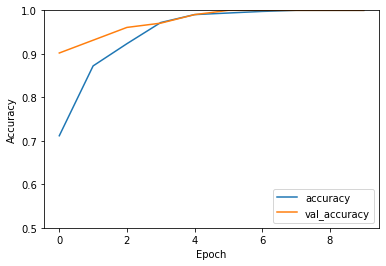

In [20]:
#Evaluate the Model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(validation_batches, verbose=2)
print('\nTest accuracy:', test_acc)

# Fine Tuning

In [21]:
base_model.trainable=True

print('Number of layers in the base model: ',len(base_model.layers))

finetune_at=155

Number of layers in the base model:  155


In [22]:
for layer in base_model.layers[:finetune_at]:
    layer.trainable=False

In [23]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy']
              )

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
fine_tuning_epochs=10
total_epochs=initial_epochs+fine_tuning_epochs

history_fine=model.fit(
train_batches,
epochs=total_epochs,
initial_epoch=history.epoch[-1],
validation_data=validation_batches
)

Epoch 10/20
26/26 [==============================] - 17s 661ms/step - loss: 0.0347 - accuracy: 1.0000 - val_loss: 0.0471 - val_accuracy: 1.0000
Epoch 11/20
26/26 [==============================] - 16s 628ms/step - loss: 0.0336 - accuracy: 1.0000 - val_loss: 0.0460 - val_accuracy: 1.0000
Epoch 12/20
26/26 [==============================] - 16s 629ms/step - loss: 0.0327 - accuracy: 1.0000 - val_loss: 0.0449 - val_accuracy: 1.0000
Epoch 13/20
26/26 [==============================] - 16s 630ms/step - loss: 0.0318 - accuracy: 1.0000 - val_loss: 0.0439 - val_accuracy: 1.0000
Epoch 14/20
26/26 [==============================] - 16s 630ms/step - loss: 0.0309 - accuracy: 1.0000 - val_loss: 0.0428 - val_accuracy: 1.0000
Epoch 15/20
26/26 [==============================] - 16s 630ms/step - loss: 0.0300 - accuracy: 1.0000 - val_loss: 0.0419 - val_accuracy: 1.0000
Epoch 16/20
26/26 [==============================] - 16s 629ms/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.0410 - val_accuracy:

In [26]:
model.evaluate(test_batches)

4/4 [==============================] - 1s 350ms/step - loss: 0.0360 - accuracy: 1.0000


[0.03599318861961365, 1.0]

4/4 - 1s - loss: 0.0376 - accuracy: 1.0000

 Fine Tuned Test accuracy: 1.0


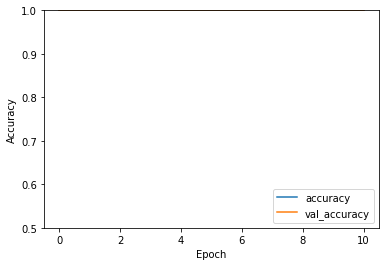

In [27]:
#Evaluate the Model
plt.plot(history_fine.history['accuracy'], label='accuracy')
plt.plot(history_fine.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(validation_batches, verbose=2)
print('\n Fine Tuned Test accuracy:', test_acc)